In [1]:
from zipfile import ZipFile
from utils.download_sample import download_from_dropbox
from utils.coordinate_utils import extract_coordinates, normalize_coords_to_pixel
from utils.imutils import *
from pathlib import Path
import napari
from napari.utils import nbscreenshot
import time


In [2]:
%gui qt

In [3]:
time.sleep(1)

In [4]:
if not Path("Stiching_Example_Dataset").exists():
    # Download and extract sample data
    example_dataset="https://www.dropbox.com/s/rhggl54sbpx9llj/Stiching_Example_Dataset.zip?dl=0"
    print("Downloading sample file from dropbox")
    download_from_dropbox(example_dataset, "_sample.zip")
    print("Extracting sample file")
    ZipFile("_sample.zip").extractall()

In [5]:
coords = extract_coordinates("Stiching_Example_Dataset/out.txt")
coords

,name,X,Y,Z,um/px
0,1_0000,3582.7,4164.4,1686.65,0.64
1,1_0001,-12396.6,11719.3,1686.63,0.64
2,1_0002,-13583.0,11726.0,1686.63,0.64
3,1_0003,-14769.3,11732.8,1686.63,0.64
4,1_0004,-15955.6,11739.5,1686.63,0.64
...,...,...,...,...,...
67,1_0067,-16003.1,3370.3,1686.63,0.64
68,1_0068,-14816.8,3363.5,1686.63,0.64
69,1_0069,-13630.5,3356.8,1686.63,0.64
70,1_0070,-12444.2,3350.1,1686.63,0.64


In [6]:
files = sorted(list(Path("Stiching_Example_Dataset").glob("*.jpg")))
files

[PosixPath('Stiching_Example_Dataset/Well1_Seq0001_1_0000.jpg'),
 PosixPath('Stiching_Example_Dataset/Well1_Seq0001_1_0001.jpg'),
 PosixPath('Stiching_Example_Dataset/Well1_Seq0001_1_0002.jpg'),
 PosixPath('Stiching_Example_Dataset/Well1_Seq0001_1_0003.jpg'),
 PosixPath('Stiching_Example_Dataset/Well1_Seq0001_1_0004.jpg'),
 PosixPath('Stiching_Example_Dataset/Well1_Seq0001_1_0005.jpg'),
 PosixPath('Stiching_Example_Dataset/Well1_Seq0001_1_0006.jpg'),
 PosixPath('Stiching_Example_Dataset/Well1_Seq0001_1_0007.jpg'),
 PosixPath('Stiching_Example_Dataset/Well1_Seq0001_1_0008.jpg'),
 PosixPath('Stiching_Example_Dataset/Well1_Seq0001_1_0009.jpg'),
 PosixPath('Stiching_Example_Dataset/Well1_Seq0001_1_0010.jpg'),
 PosixPath('Stiching_Example_Dataset/Well1_Seq0001_1_0011.jpg'),
 PosixPath('Stiching_Example_Dataset/Well1_Seq0001_1_0012.jpg'),
 PosixPath('Stiching_Example_Dataset/Well1_Seq0001_1_0013.jpg'),
 PosixPath('Stiching_Example_Dataset/Well1_Seq0001_1_0014.jpg'),
 PosixPath('Stiching_Exam

In [7]:
normalized_coords=normalize_coords_to_pixel(coords).to_numpy()

In [8]:
v = napari.Viewer()

2021-06-21 13:34:55,701 [INFO] WRITING LOG OUTPUT TO /home/hilsenst/.cellpose/run.log


In [12]:
# skip first image as it is an outlier (stage position wise)
mosaic_layers = []
for file, coord in zip(files[1:], normalized_coords[1:]):
    im = load_image(file)
    im = transpose(select_channel(crop_black_border(im),0))
    layer = v.add_image(im, translate=coord, name=file.stem)
    mosaic_layers.append(layer)

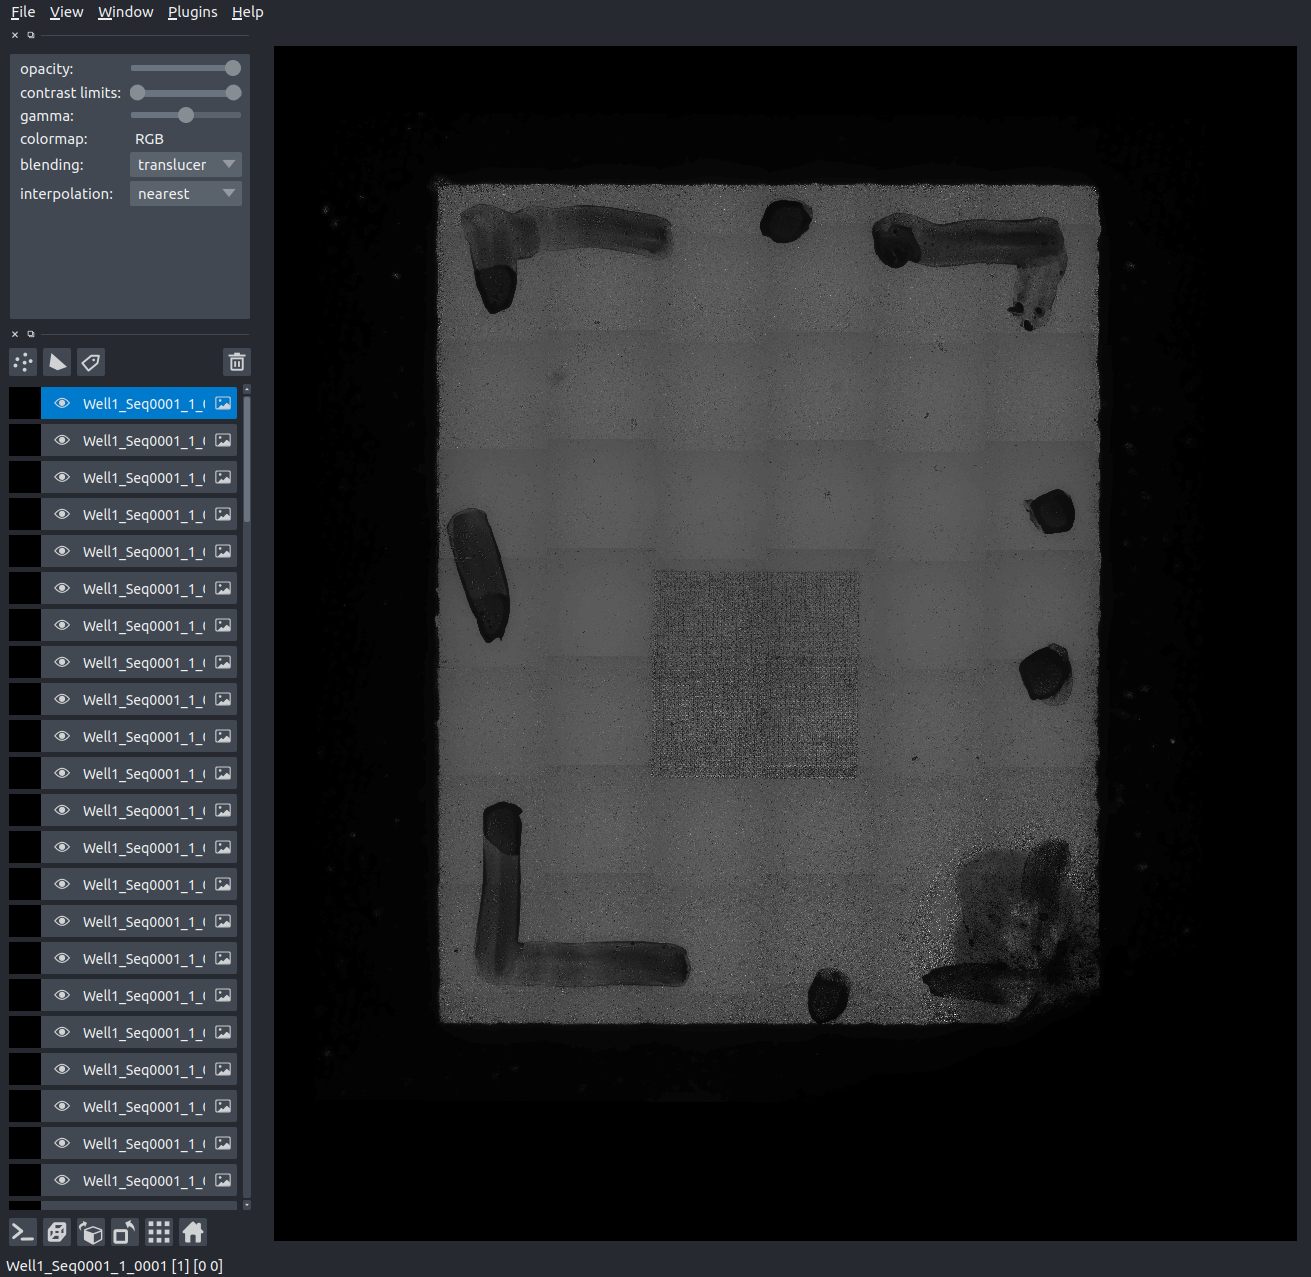

In [13]:
nbscreenshot(v)

In [14]:
for layer in mosaic_layers:
    print(layer.affine.affine_matrix)

[[ 1.00000000e+00  0.00000000e+00 -1.93696875e+04]
 [ 0.00000000e+00  1.00000000e+00  1.83114062e+04]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 1.00000000e+00  0.00000000e+00 -2.12234375e+04]
 [ 0.00000000e+00  1.00000000e+00  1.83218750e+04]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 1.00000000e+00  0.00000000e+00 -2.30770312e+04]
 [ 0.00000000e+00  1.00000000e+00  1.83325000e+04]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 1.00000000e+00  0.00000000e+00 -2.49306250e+04]
 [ 0.00000000e+00  1.00000000e+00  1.83429688e+04]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 1.00000000e+00  0.00000000e+00 -2.67842188e+04]
 [ 0.00000000e+00  1.00000000e+00  1.83535938e+04]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 1.00000000e+00  0.00000000e+00 -2.86378125e+04]
 [ 0.00000000e+00  1.00000000e+00  1.83640625e+04]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 1.00000000e+00  0.00000000e+00 -3.04914062e+04]
 [ 0.00000000e+00  1.0000